## Using InfoPy to reproduce Schreiber's paper examples

In [1]:
import numpy             as np 
import matplotlib.pyplot as plt 
import pandas            as pd
import multiprocessing
from   joblib            import Parallel, delayed

In [2]:
M         = 100     # Number of elements in the map
Transient = 100000  # Transient time
T         = 100000  # Simulation time
    
def tentMap(x_in):
    ###############################################################################
    # Description: Equations for the ulam map. Return the next value of the map
    # given the previous one.
    # > Inputs: 
    # x_in: Input or previous value of the map
    # > Outputs:
    # Next value of the map.
    ###############################################################################
    return x_in * 2.0 * (x_in < 0.5) + (2 - 2 * x_in) * (x_in >= 0.5)
    
def simulateMap(M, Transient, T, coupling = 0.05):
    ###############################################################################
    # Description: Simulate tent.
    # > Inputs:
    # f_map: Map function
    # coupling: Counpling between the map elements
    # M: Number of elements in the map
    # Transiente: Transient time
    # T: Simulation time
    # > Output
    # binMapValues: The binary output of each map element
    ###############################################################################
        
    # Initializing map values. For the tent map it's initialized with random uniform values.
    values = np.random.rand(M)  

    # Run transient
    for t in range(1, Transient):
        for i in range(len(values)):
            if i == 0:
                values[i] = tentMap( coupling * values[-1] + (1 - coupling) * values[i])
            else:
                values[i] = tentMap( coupling * values[i-1] + (1 - coupling) * values[i])


    mapValues       = np.zeros([T, M])
    mapValues[0, :] = values

    # Run the map simulation
    for t in range(1, T):
        for m in range(0, M):
            if m == 0:
                mapValues[t, m] = tentMap( coupling * mapValues[t-1, -1] + (1 - coupling) * mapValues[t-1, m] )
            else:
                mapValues[t, m] = tentMap( coupling * mapValues[t-1, m-1] + (1 - coupling) * mapValues[t-1, m] )

    binMapValues = (mapValues >= 0.5).astype(int)
    return binMapValues
    
def simulateMapCouplings(M, Transient, T, couplings = np.arange(0, 0.052, 0.002), n_jobs = 1):
    ###############################################################################
    # Description: This function allows to run simulateMap in parallel.
    # > Inputs:
    # f_map: Map function
    # M: Number of elements in the map
    # Transiente: Transient time
    # T: Simulation time
    # couplings: A numpy array with coupling values
    # n_jobs: Number of jobs to use
    # > Output
    # binMapValues: The binary output of each map element for each coupling
    ###############################################################################
    binMapValues = Parallel(n_jobs=n_jobs, backend='loky', max_nbytes=1e6)(
            delayed(simulateMap)(M, Transient, T, c) for c in couplings
            )
    
    return np.squeeze(binMapValues)

In [3]:
def tentMapTE(couplings = np.arange(0, 0.052, 0.002)):
    ###############################################################################
    # Description: Returns analytical values of TE for the tent map
    # > Inputs:
    # couplings: A numpy array with coupling values
    # n_jobs: Number of jobs to use
    # > Output
    # Transfer entropy as a funtion of the coupling for the tent map
    ###############################################################################
    return (0.77**2)*(couplings**2)/np.log(2)

In [4]:
couplings    = np.arange(0, 0.052, 0.002)
binMapValues = simulateMapCouplings(M, 100, T, couplings, n_jobs = -1)

In [5]:
from infoPy.discrete import BinTransferEntropy

In [6]:
def pairTE(binMapValues, M, i):
    if i == 0:
        return BinTransferEntropy(binMapValues[:,M-1], binMapValues[:,0], lag = 0)
    else:
        return BinTransferEntropy(binMapValues[:,i-1], binMapValues[:,i], lag = 0)

In [17]:
TE = np.zeros([couplings.shape[0], M-1])

for i in range( couplings.shape[0] ):
    TE[i] = Parallel(n_jobs=-1, backend='loky', max_nbytes=1e6)
                    (delayed(pairTE)(binMapValues[i], M, m) for m in range(1, M)
                    )

In [18]:
TE_tent = tentMapTE(couplings)

Text(0.5, 0, 'Counpling')

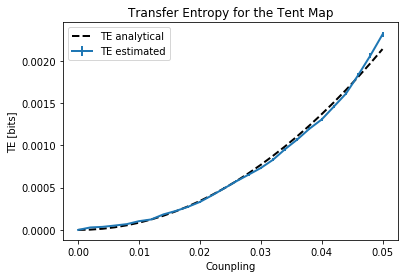

In [26]:
plt.figure()
plt.plot(couplings, TE_tent, 'k--', lw=2)
plt.errorbar(couplings, TE.mean(axis=1), TE.std(axis=1) / np.sqrt(M), lw=2)
plt.legend(['TE analytical', 'TE estimated'])
plt.title('Transfer Entropy for the Tent Map')
plt.ylabel('TE [bits]')
plt.xlabel('Counpling')